In [1]:
# Name: Anay Abhijit Joshi
# Homework 3 - Medical Image Segmentation

In [2]:
# Here are the necessary Python libraries and modules
import os
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, concatenate

In [3]:
# Here is the name of the ZIP file that we want to extract
zip_filename = "Data.zip"

# Now, do the extraction. To be safe, we first check if the file is a valid ZIP archive, using a conditional loop.
if zipfile.is_zipfile(zip_filename):
    # If the file is a valid ZIP archive, we can proceed with the extraction.
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        # Extract all the contents of the ZIP file into a new directory called
        zip_ref.extractall("data")
    # Print a message to indicate that the extraction was successful.
    print("Extraction completed successfully.")
# If the file is not a valid ZIP archive, print an error message.
else:
    # Print an error message if the file is not a valid ZIP archive.
    print("Error: The file is not a valid ZIP archive.")

Extraction completed successfully.


In [4]:
# Again, the ZIP file
zip_filename = "Data.zip"

# The folder where the data will be extracted
extract_path = "data"

# Extract the data from the ZIP file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# The extracted data is structured as follows:
train_folder = os.path.join(extract_path, 'train')
test_folder = os.path.join(extract_path, 'test')

# Display the folder structure via the print statements
print(f"Success! Extraction completed.\n")
print(f"Directories are structured as follows:")
print(f"Train folder: {train_folder}")
print(f"Test folder: {test_folder}")

Success! Extraction completed.

Directories are structured as follows:
Train folder: data/train
Test folder: data/test


In [13]:
# Extraction path: data/Data
extract_path = "data/Data"

# Now, let's resize the images and masks to a common size.
def resize_image(image, new_size):
    image = image.resize(new_size, Image.ANTIALIAS)
    return image

# Define the new size for the images and masks.
new_image_size = (256, 256)

# Load and preprocess the data.
def load_and_prepare_retina_data(data_type="train"):
    images = []
    masks = []

    # Define the paths for the images and masks.
    image_path = os.path.join(extract_path, data_type, "image")
    # Define the path for the masks.
    mask_path = os.path.join(extract_path, data_type, "mask")

    # Check if the paths exist.
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        raise FileNotFoundError(f"One or both paths do not exist:\nImages: {image_path}\nMasks: {mask_path}")
    # Iterate over the files in the image path using "for" loop.
    for filename in sorted(os.listdir(image_path)):
        if not filename.endswith('.png'):
            continue
        # Read the image file.
        img = tf.io.read_file(os.path.join(image_path, filename))
        img = tf.image.decode_png(img, channels=1)
        # Resize the image.
        img = tf.image.resize(img, new_image_size)
        # Append the image to the images list.
        images.append(img)
        # Read the mask file.
        mask = tf.io.read_file(os.path.join(mask_path, filename))
        mask = tf.image.decode_png(mask, channels=1)
        # Resize the mask.
        mask = tf.image.resize(mask, new_image_size)
        # Append the mask to the masks list.
        masks.append(mask)
    # Return the images and masks as a stack.
    return tf.stack(images), tf.stack(masks)

# Load and preprocess the data for training and testing.
train_images, train_masks = load_and_prepare_retina_data(data_type="train")
test_images, test_masks = load_and_prepare_retina_data(data_type="test")

# # Here, I will normalize the images and masks.
# train_images = tf.cast(train_images, tf.float32) / 255.0
# test_images = tf.cast(test_images, tf.float32) / 255.0
# train_masks = tf.cast(train_masks, tf.float32) / 255.0
# test_masks = tf.cast(test_masks, tf.float32) / 255.0

# No Normalization
train_images = tf.cast(train_images, tf.float32)
test_images = tf.cast(test_images, tf.float32)
train_masks = tf.cast(train_masks, tf.float32)
test_masks = tf.cast(test_masks, tf.float32)

# Print if successful.
print("Success! Data loaded and preprocessed.")

Success! Data loaded and preprocessed.


In [14]:
# Here is the IoU and Dice Coefficient functions and the data augmentation generator
# # First, IoU function calculates the Intersection over Union metric
def IoU(
    y_true,
    y_pred,
    smooth=1e-5):
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    y_true = tf.clip_by_value(y_true, 0, 1)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    iou = (intersection + smooth) / (union - intersection + smooth)
    # Return the mean of the Intersection over Union values
    return tf.reduce_mean(tf.clip_by_value(iou, 0, 1))

# # Next, Dice Coefficient function calculates the Dice Coefficient metric
def DiceCoefficient(
    y_true,
    y_pred,
    smooth=1e-5):
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    y_true = tf.clip_by_value(y_true, 0, 1)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    dice = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) + smooth)
    # Return the mean of the Dice Coefficient values
    return tf.reduce_mean(tf.clip_by_value(dice, 0, 1))

# Here is the customized loss function for the model
# Referred various things online:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/tversky
# https://medium.com/@j.ali.hab/on-custom-loss-functions-in-keras-3af88cf59e48
def custom_loss(y_true, y_pred):
    # This is for the binary cross-entropy loss between the true labels and predicted labels.
    base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # This is the penalty term to push predictions towards the center (0.5) to avoid extreme values for balanced outputs
    penalty = tf.reduce_mean(tf.square(y_pred - 0.5))
    # Return the combined loss: base binary cross-entropy plus a small weight (0.1) for the penalty term.
    return base_loss + 0.1 * penalty

# Finally, the data augmentation generator is defined for the model to use and train on
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# Let's create a generic U-Net model with a variable number of layers for U-Net architecture(s).
# The model will have have a configurable number of layers, and will be compiled with the Adam optimizer,
# binary crossentropy loss, and DiceCoefficient and IoU metrics.
def retina_unet_model(num_layers, base_filter = 64, input_shape = (None, None, 1)):
    # Define the input layer with the shape of the input image
    inputs = Input(input_shape)
    # Let's define a list to store the output of each layer
    x = inputs
    # Let's define a list to store the output of each down layer, initialized as an empty list, initially
    down_layers = []
    # Let's iterate over the number of layers using the range function
    for i in range(num_layers):
        # First Convolutional Layer
        # Define the convolutional layer with 64 * (2**i) filters, a kernel size of (3, 3), ReLU activation function, and same padding
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        # # Define the batch normalization layer
        # x = BatchNormalization()(x)
        # Second Convolutional Layer
        # Again, define the convolutional layer with 64 * (2**i) filters, a kernel size of (3, 3), ReLU activation function, and same padding
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        # # Define the batch normalization layer
        # x = BatchNormalization()(x)
        # If the current layer is not the last layer, apply dropout with a rate of 0.5
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        # Define the max pooling layer with a pool size of (2, 2) and same padding
        x = MaxPooling2D((2, 2), padding='same')(x)

    # Define the bottleneck layer
    x = Dropout(0.5)(x)

    # Let's iterate over the number of layers in reverse order using the range function again
    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        # x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
        # x = BatchNormalization()(x)
    # Define the output layer with a single filter, a kernel size of (1, 1), and a sigmoid activation function
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    # Return the model with the input and output layers
    return Model(inputs=inputs, outputs=outputs)

In [16]:
# Here, "test_model" function, as per the given requirements.
def test_model(*, model_name: str):
  """
  Test a U-Net model with a specified number of layers and evaluate its performance.

  -----------
  Function Parameters:
  -----------
  model_name : str
      The name of the model to train and evaluate. Please choose the model name:
      - 'UNet2': U-Net model with 2 layers.
      - 'UNet3': U-Net model with 3 layers.
      - 'UNet4': U-Net model with 4 layers.

  -----------

  Note:
  -----
  This function uses keyword-only arguments, and the `model_name` parameter is required.
  """

  # Here, I have considered the following model names: 'UNet2', 'UNet3', 'UNet4' for U-Net models with 2, 3, and 4 layers, respectively.

  # ################################################# U-Net 2 layers #######################################################
  if model_name == "UNet2":
    # Train and evaluate U-Net model with 2 layers of U-Net, call the function defined above
    model_2 = retina_unet_model(num_layers=2)
    # Compile the model, reducing the learning rate...
    model_2.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[DiceCoefficient, IoU])
    # Setting up early stopping to prevent overfitting of the data
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Training the model and saving the training history
    history = model_2.fit(train_images, train_masks, batch_size=16, epochs=5, validation_split=0.1, callbacks=[early_stopping])
    # Predict on test images for evaluation
    predicted_masks_2 = model_2.predict(test_images)
    # Save the predicted masks for future use (Step 6)
    np.save('predicted_masks_2.npy', predicted_masks_2)
    # Calculate Dice and IoU scores
    dice_score_2 = DiceCoefficient(test_masks, predicted_masks_2)
    # Calculate IoU score
    iou_score_2 = IoU(test_masks, predicted_masks_2)
    # Let's print the scores of Dice and IoU
    print(f" ")
    print(f" ")
    print(f"                           U-Net 2 Layers -> Dice Score: {dice_score_2.numpy()}")
    print(f"                           U-Net 2 Layers -> IoU Score: {iou_score_2.numpy()}")
    # Timestamp
    timestamp = datetime.now()
    print(f" ")
    print(f" ")
    print("                           Timestamp:", timestamp)
    print(f" ")

    # Plotting the training history
    plt.figure(figsize=(8, 11))

    # Dice Coefficient plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['dice_coefficient'], color="red", linestyle="--", linewidth=2, label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], color="blue", linestyle=":", linewidth=2, label='Validation Dice Coefficient')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('Dice Coefficient', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation Dice Coefficient', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    # IoU plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['io_u'], color="red", linestyle="--", linewidth=2, label='Train IoU')
    plt.plot(history.history['val_io_u'], color="blue", linestyle=":", linewidth=2, label='Validation IoU')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('IoU', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation IoU', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    plt.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

  # ################################################# U-Net 3 layers #######################################################
  # Now, it's time for U-Net models with 3 layers
  elif model_name == "UNet3":
    # Train and evaluate U-Net model with 3 layers, call the function defined above
    model_3 = retina_unet_model(num_layers=3)
    # Compile the U-Net 3 model, reducing the learning rate for more stable training
    model_3.compile(optimizer=Adam(learning_rate=1e-7), loss=custom_loss, metrics=[DiceCoefficient, IoU])
    # Setting up early stopping to prevent overfitting and ensure the model stops training when improvements plateau
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Train the U-Net 3 model and save the training history for further analysis
    history = model_3.fit(train_images, train_masks, batch_size=2, epochs=10, validation_split=0.1, callbacks=[early_stopping])

    # Predict on test images for evaluation
    predicted_masks_3 = model_3.predict(test_images)
    # Save the predicted masks for future use (Step 6)
    np.save('predicted_masks_3.npy', predicted_masks_3)
    # Calculate Dice and IoU scores
    dice_score_3 = DiceCoefficient(test_masks, predicted_masks_3)
    # Calculate IoU score
    iou_score_3 = IoU(test_masks, predicted_masks_3)

    # Let's print the scores of Dice and IoU
    print(f" ")
    print(f" ")
    print(f"                           U-Net 3 Layers -> Dice Score: {dice_score_3.numpy()}")
    print(f"                           U-Net 3 Layers -> IoU Score: {iou_score_3.numpy()}")
    # Timestamp
    timestamp = datetime.now()
    print(f" ")
    print(f" ")
    print("                           Timestamp:", timestamp)
    print(f" ")

    # Plotting the training history
    plt.figure(figsize=(8, 11))

    # Dice Coefficient plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['dice_coefficient'], color="red", linestyle="--", linewidth=2, label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], color="blue", linestyle=":", linewidth=2, label='Validation Dice Coefficient')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('Dice Coefficient', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation Dice Coefficient', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    # IoU plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['io_u'], color="red", linestyle="--", linewidth=2, label='Train IoU')
    plt.plot(history.history['val_io_u'], color="blue", linestyle=":", linewidth=2, label='Validation IoU')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('IoU', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation IoU', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    plt.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

  # ################################################# U-Net 4 layers (Extra) #######################################################
  elif model_name == "UNet4":
      # Train and evaluate U-Net model with 4 layers, call the function defined above
      model_4 = retina_unet_model(num_layers=4)
      # Compile the U-Net 4 model with a reduced learning rate to avoid overshooting the optimal solution
      model_4.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[DiceCoefficient, IoU])
      # Set up early stopping to stop training when no significant improvement in validation loss is observed
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
      # Train the U-Net 4 model and store the training history to evaluate training performance and progress
      history = model_4.fit(train_images, train_masks, batch_size=8, epochs=5, validation_split=0.1, callbacks=[early_stopping])
      # Predict on test images for evaluation
      predicted_masks_4 = model_4.predict(test_images)
      # Save the predicted masks for future use (Step 6)
      np.save('predicted_masks_4.npy', predicted_masks_4)
      # Calculate Dice and IoU scores
      dice_score_4 = DiceCoefficient(test_masks, predicted_masks_4)
      # Calculate IoU score
      iou_score_4 = IoU(test_masks, predicted_masks_4)

      # Let's print the scores of Dice and IoU
      print(f" ")
      print(f" ")
      print(f"                           U-Net 4 Layers -> Dice Score: {dice_score_4.numpy()}")
      print(f"                           U-Net 4 Layers -> IoU Score: {iou_score_4.numpy()}")
      # Timestamp
      timestamp = datetime.now()
      print(f" ")
      print(f" ")
      print("                           Timestamp:", timestamp)
      print(f" ")

      # Plotting the training history
      plt.figure(figsize=(8, 11))

      # Dice Coefficient plot
      plt.subplot(2, 1, 1)
      plt.plot(history.history['dice_coefficient'], color="red", linestyle="--", linewidth=2, label='Train Dice Coefficient')
      plt.plot(history.history['val_dice_coefficient'], color="blue", linestyle=":", linewidth=2, label='Validation Dice Coefficient')

      # Plot's Labels
      plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
      plt.ylabel('Dice Coefficient', fontsize=11, color="navy", fontweight="bold")
      plt.title('Training vs Validation Dice Coefficient', fontsize=15, color="black", fontweight="bold")

      # Plot's Legend
      plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

      # Plot's Grid
      plt.grid(True, linestyle="--", alpha=0.5)

      # Plot's Background Color
      plt.gca().set_facecolor("#FFF700")

      # IoU plot
      plt.subplot(2, 1, 2)
      plt.plot(history.history['io_u'], color="red", linestyle="--", linewidth=2, label='Train IoU')
      plt.plot(history.history['val_io_u'], color="blue", linestyle=":", linewidth=2, label='Validation IoU')

      # Plot's Labels
      plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
      plt.ylabel('IoU', fontsize=11, color="navy", fontweight="bold")
      plt.title('Training vs Validation IoU', fontsize=15, color="black", fontweight="bold")

      # Plot's Legend
      plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

      # Plot's Grid
      plt.grid(True, linestyle="--", alpha=0.5)

      # Plot's Background Color
      plt.gca().set_facecolor("#FFF700")

      plt.subplots_adjust(hspace=0.5)

      plt.tight_layout()
      plt.show()
  # Finally, if the user enters an invalid model name, then the following message will be displayed to the user.
  else:
    print(f"Invalid Model Name! Please choose from 'UNet2', 'UNet3', or 'UNet4'.")

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - dice_coefficient: 0.2788 - io_u: 0.1623 - loss: -75.5023 - val_dice_coefficient: 0.2788 - val_io_u: 0.1624 - val_loss: -87.9904
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - dice_coefficient: 0.3011 - io_u: 0.1777 - loss: -175.2487 - val_dice_coefficient: 0.2758 - val_io_u: 0.1604 - val_loss: -132.5063
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - dice_coefficient: 0.3019 - io_u: 0.1782 - loss: -267.8921 - val_dice_coefficient: 0.2724 - val_io_u: 0.1582 - val_loss: -181.7708
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - dice_coefficient: 0.2961 - io_u: 0.1743 - loss: -377.7395 - val_dice_coefficient: 0.2694 - val_io_u: 0.1562 - val_loss: -234.5885
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - dice_coefficient: 0.2954 - io_u: 0.1737 - loss: -495.8208 - val_dice_coefficient: 0.2666 - val_io_u: 0.1543 - val_loss: -296.9899
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
 
 
                           U-Net 2 Layers -> Dice Score:

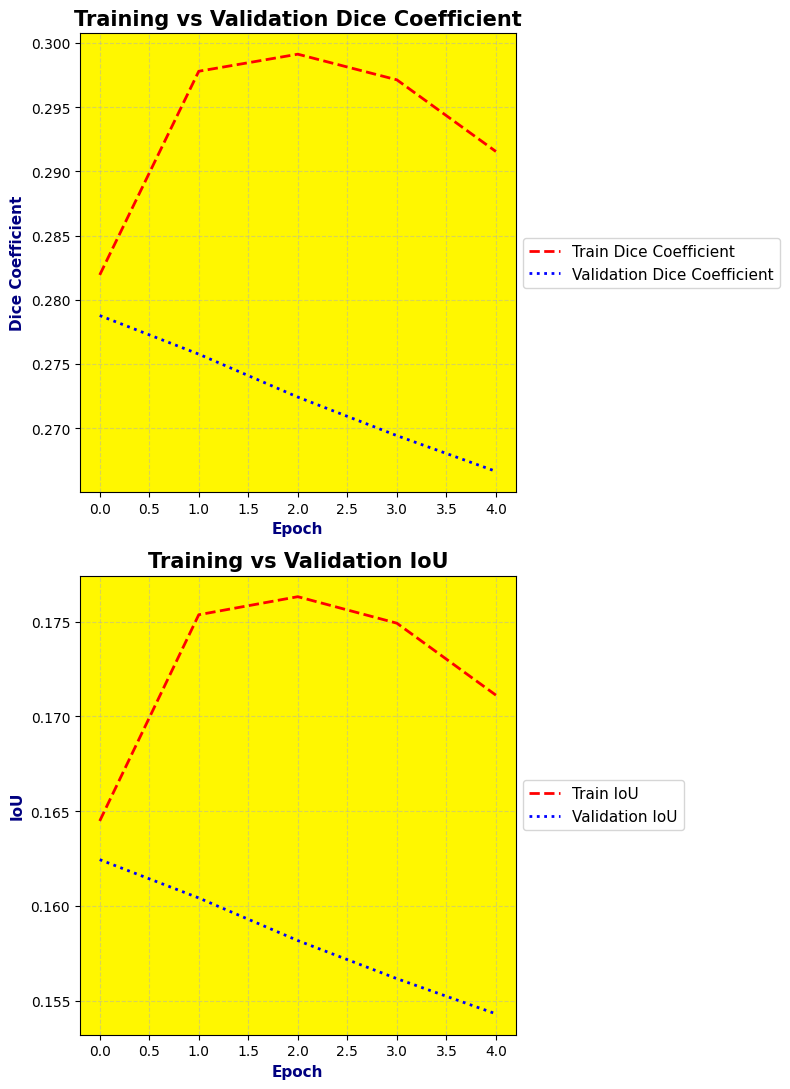

In [17]:
test_model(model_name="UNet2")

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - dice_coefficient: 0.2854 - io_u: 0.1668 - loss: -107.4189 - val_dice_coefficient: 0.2726 - val_io_u: 0.1583 - val_loss: -43.9650
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - dice_coefficient: 0.2912 - io_u: 0.1708 - loss: -121.3250 - val_dice_coefficient: 0.2736 - val_io_u: 0.1589 - val_loss: -47.1025
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - dice_coefficient: 0.2893 - io_u: 0.1694 - loss: -126.4106 - val_dice_coefficient: 0.2743 - val_io_u: 0.1594 - val_loss: -50.2684
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - dice_coefficient: 0.2918 - io_u: 0.1712 - loss: -140.1153 - val_dice_coefficient: 0.2750 - val_io_u: 0.1599 - val_loss: -53.4729
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - dice_coefficient: 0.2838 - io_u: 0.1657 - loss: -145.2210 - val_dice_coefficient: 0.2755 - val_io_u: 0.1602 - val_loss: -56.6567
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - dice_coefficient: 0.2974 - io_u: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
 
 
                           U-Net 3 Layers -> Dice Score: 0.30799880623817444
                           U-Net 3 Layers -> IoU Score: 0.18222160637378693
 
 
                           Timestamp: 2024-11-08 03:21:44.837869
 


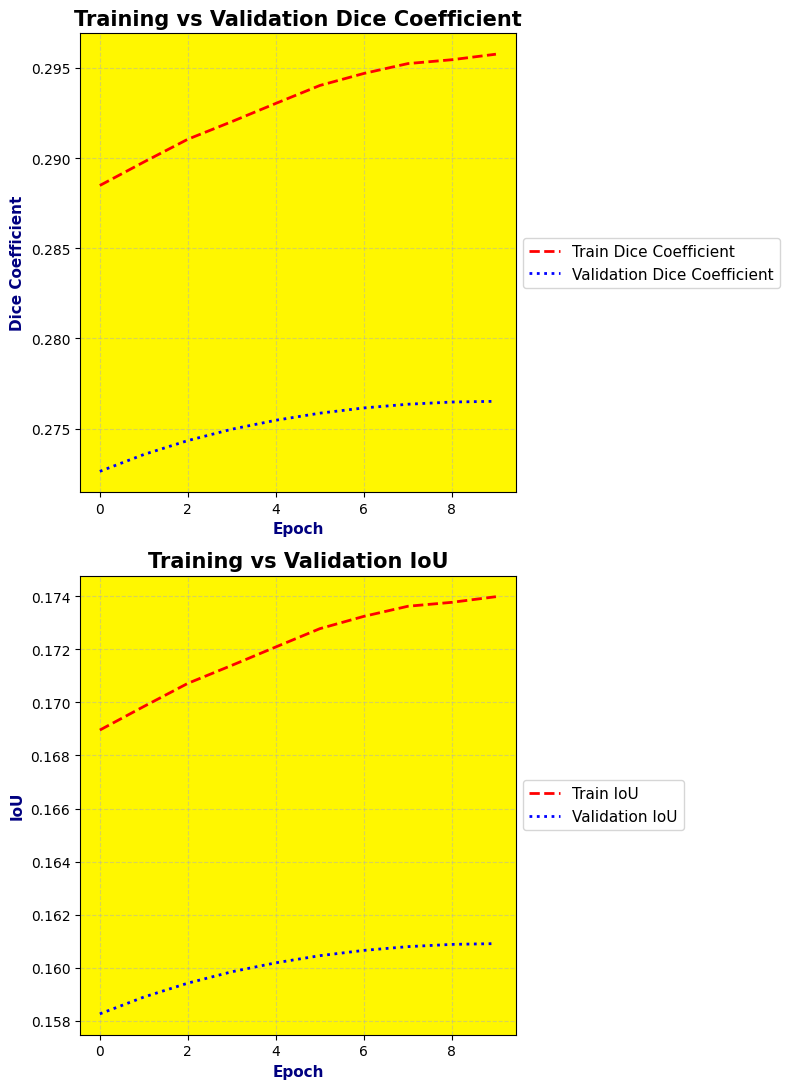

In [18]:
test_model(model_name="UNet3")

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 693ms/step - dice_coefficient: 0.2937 - io_u: 0.1726 - loss: -293.7153 - val_dice_coefficient: 0.2644 - val_io_u: 0.1528 - val_loss: -235.7940
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - dice_coefficient: 0.2833 - io_u: 0.1654 - loss: -1248.9252 - val_dice_coefficient: 0.2552 - val_io_u: 0.1467 - val_loss: -563.5593
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - dice_coefficient: 0.2793 - io_u: 0.1627 - loss: -5478.2153 - val_dice_coefficient: 0.2529 - val_io_u: 0.1452 - val_loss: -1897.4200
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - dice_coefficient: 0.2812 - io_u: 0.1641 - loss: -26704.2051 - val_dice_coefficient: 0.2525 - val_io_u: 0.1450 - val_loss: -8596.8906
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - dice_coefficient: 0.2814 - io_u: 0.1642 - loss: -140884.6250 - val_dice_coefficient: 0.2525 - val_io_u: 0.1450 - val_loss: -45663.2695


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
 
 
                           U-Net 4 Layers -> Dice Score: 0.27717503905296326
                           U-Net 4 Layers -> IoU Score: 0.16103629767894745
 
 
                           Timestamp: 2024-11-08 03:22:20.384676
 


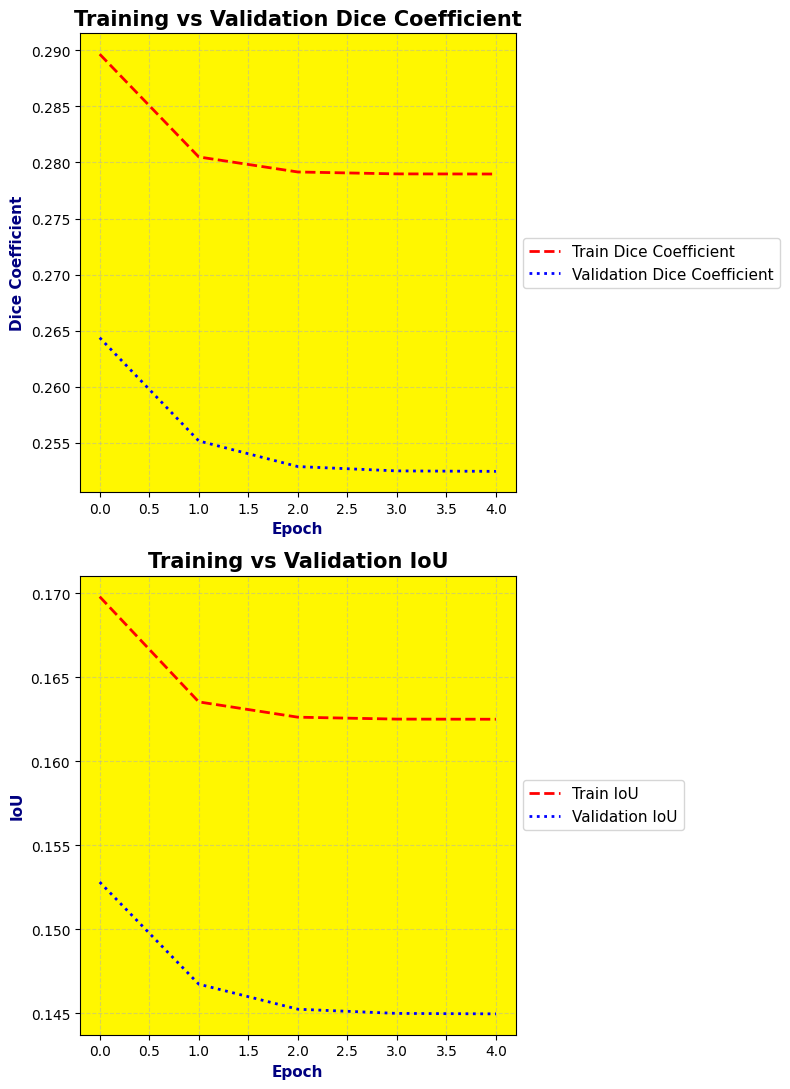

In [19]:
test_model(model_name="UNet4")

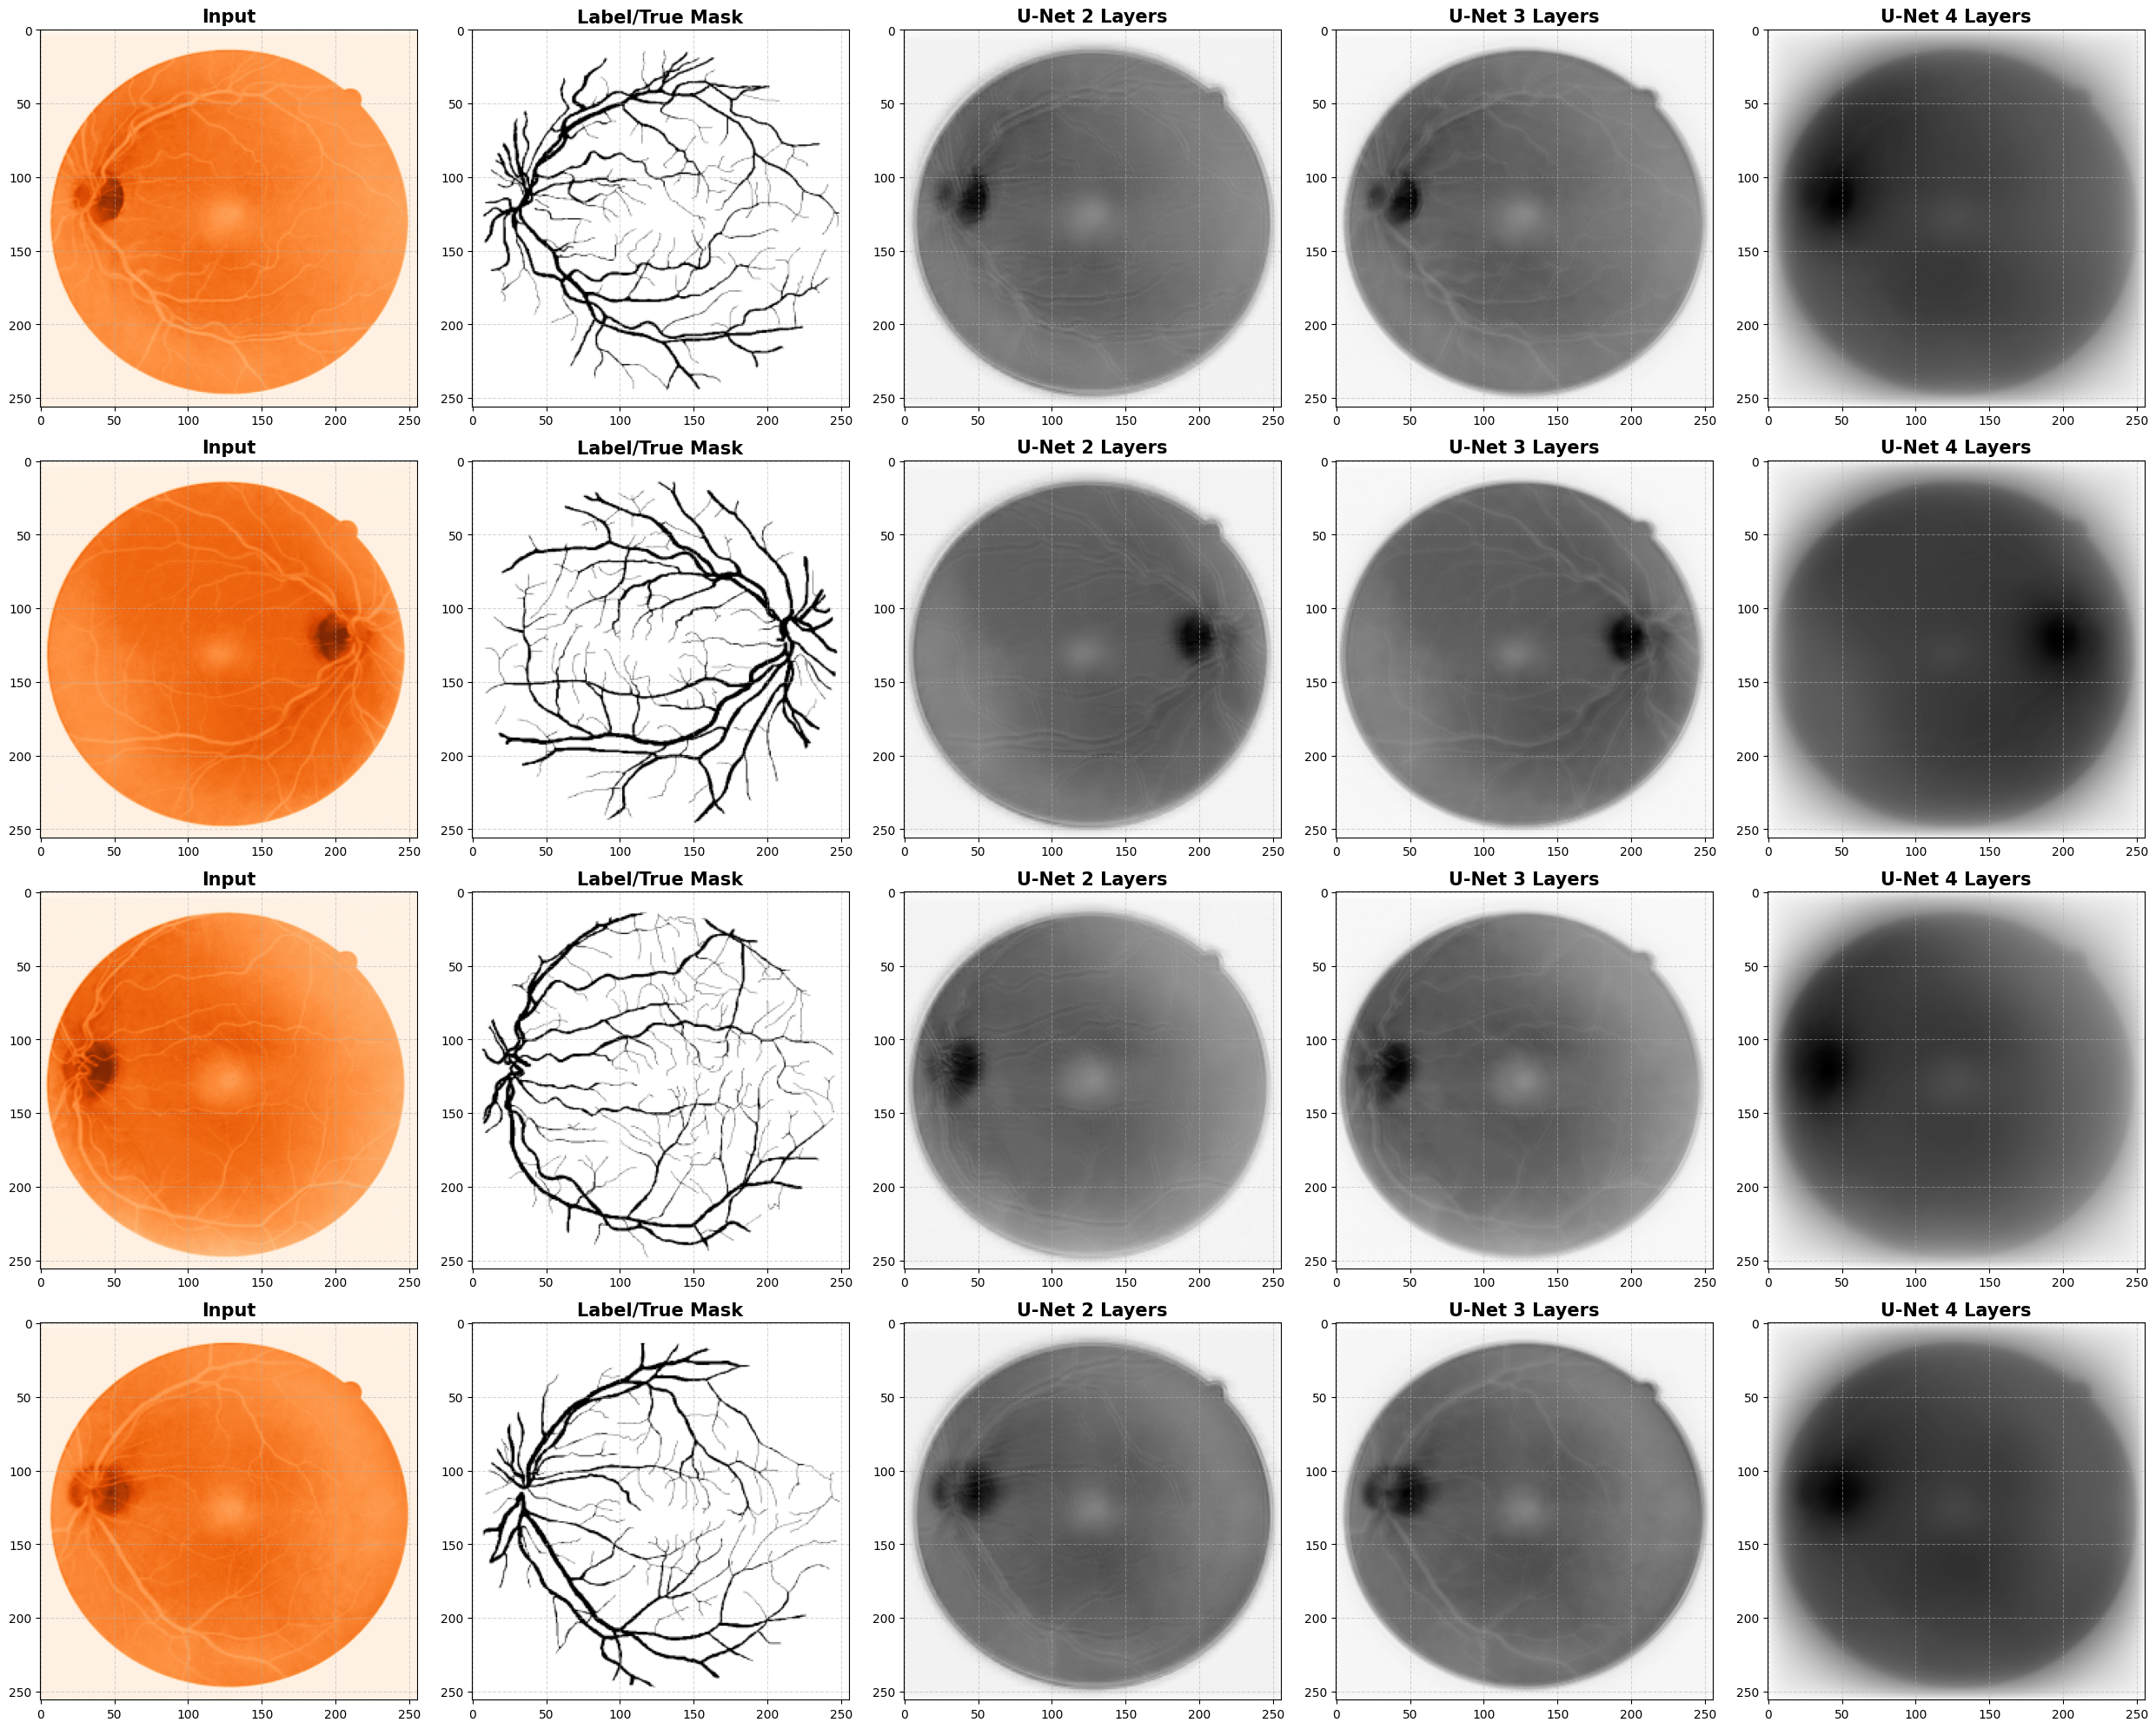

In [12]:
# Now, I don't want to run the entire code again, so I will load the predicted masks from the saved numpy files and plot them.
# Load the predicted masks for U-Net 2 Layers
predicted_masks_2 = np.load('predicted_masks_2.npy')
# Load the predicted masks for U-Net 3 Layers
predicted_masks_3 = np.load('predicted_masks_3.npy')
# Load the predicted masks for U-Net 4 Layers
predicted_masks_4 = np.load('predicted_masks_4.npy')

# Now, let's plot the images with their true masks and predicted masks
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
# Loop through each image
for i in range(4):
    # Plot the images with their true masks and predicted masks
    # Input
    ax[i, 0].imshow(test_images[i, ..., 0], cmap="Oranges")         # Using a different colormap for better visualization and differentiation from U-Net 2, 3, 4 Layers and Label/True Mask
    # True mask or Label
    ax[i, 1].imshow(test_masks[i, ..., 0], cmap="Greys")            # Using a different colormap for better visualization and differentiation from U-Net 2, 3, 4 Layers and Input
    # Plot the predicted masks for U-Net 2, 3, and 4 layers
    # U-Net 2 Layers
    ax[i, 2].imshow(predicted_masks_2[i, ..., 0], cmap="gray")
    # U-Net 3 Layers
    ax[i, 3].imshow(predicted_masks_3[i, ..., 0], cmap="gray")
    # U-Net 4 Layers
    ax[i, 4].imshow(predicted_masks_4[i, ..., 0], cmap="gray")

    # Setting the titles for each subplot for better understanding
    ax[i, 0].set_title("Input", fontsize=15, color="black", fontweight="bold")
    ax[i, 1].set_title("Label/True Mask", fontsize=15, color="black", fontweight="bold")
    ax[i, 2].set_title("U-Net 2 Layers", fontsize=15, color="black", fontweight="bold")
    ax[i, 3].set_title("U-Net 3 Layers", fontsize=15, color="black", fontweight="bold")
    ax[i, 4].set_title("U-Net 4 Layers", fontsize=15, color="black", fontweight="bold")

    # Now, iterate over each subplot
    for j in range(5):
        ax[i, j].grid(True, linestyle="--", alpha=0.5)
        ax[i, j].set_facecolor("#FFF700")
# Display the plot
plt.tight_layout()
plt.show()